In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
df1=pd.read_csv('df_fe_without_preprocessing_train.csv',encoding='latin-1')
df2=pd.read_csv('nlp_features_train.csv',encoding='latin-1')
df3=pd.DataFrame()
df3['questions']=df1.question1+''+df1.question2
df3['id']=df1.id
print(df3.shape)
#print(df1.head(2))
print(df1.shape)
#print(df2.head(2))
print(df2.shape)

(404290, 2)
(404290, 17)
(404290, 21)


In [3]:
df=pd.merge(df1,df2,on='id')
df=df.merge(df3,on='id',how='left')


In [4]:
df=df.sample(100000)
print(df.shape)
y=df['is_duplicate_x']
print(y.shape)
df=df.drop('is_duplicate_x',axis=1)
print(df.shape)

(100000, 38)
(100000,)
(100000, 37)


In [24]:
x_tr,x_test,train_y,test_y=train_test_split(df,y,test_size=0.3)
x_tr_quest=x_tr['questions']
x_test_quest=x_test['questions']
print(x_tr_quest.head())
x_tr=x_tr.drop('questions',axis=1)
x_test=x_test.drop('questions',axis=1)
print('training samples=',x_tr.shape)
print('testing samples=',x_test.shape)
train_feats = x_tr.drop(["id", "is_duplicate_y", "qid1_x", "qid2_x", "qid1_y", "qid2_y", "question1_y", "question2_y", "question1_x", "question2_x"], axis = 1)
print(train_feats.shape)
test_feats = x_test.drop(["id", "is_duplicate_y", "qid1_x", "qid2_x", "qid1_y", "qid2_y", "question1_y", "question2_y", "question1_x", "question2_x"], axis = 1)
print(test_feats.shape)

363561    Why isn't Indian markets struck hard by intern...
189839    why is the sky blueWhy is the sky blue where t...
364567    What does "convergence" mean in mathematics?Wh...
268463    How much does a youtuber with 5 million subscr...
303148    Where can I buy stamps in Austin, TX?Where is ...
Name: questions, dtype: object
training samples= (70000, 36)
testing samples= (30000, 36)
(70000, 26)
(30000, 26)


In [15]:
tfidf_vect=TfidfVectorizer(lowercase=False)
tfidf_vect.fit(x_tr_quest.values.astype('U'))
print("some sample features(unique words in the corpus)",tfidf_vect.get_feature_names()[0:10])
print('='*50)
tfidf_tr=tfidf_vect.transform(x_tr_quest.values.astype('U'))
print(tfidf_tr.shape)

tfidf_test=tfidf_vect.transform(x_test_quest.values.astype('U'))



some sample features(unique words in the corpus) ['00', '000', '00000000', '00000074', '0000021210', '0001', '000USD', '001', '0019', '007']
(70000, 48238)


In [16]:
import scipy
x_train_final =scipy.sparse.hstack((tfidf_tr, train_feats.astype(float)))
x_test_final =scipy.sparse.hstack((tfidf_test, test_feats.astype(float)))
print(x_train_final.shape)
print(x_test_final.shape)

(70000, 48264)
(30000, 48264)


In [17]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing B in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing A in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8841755123676068


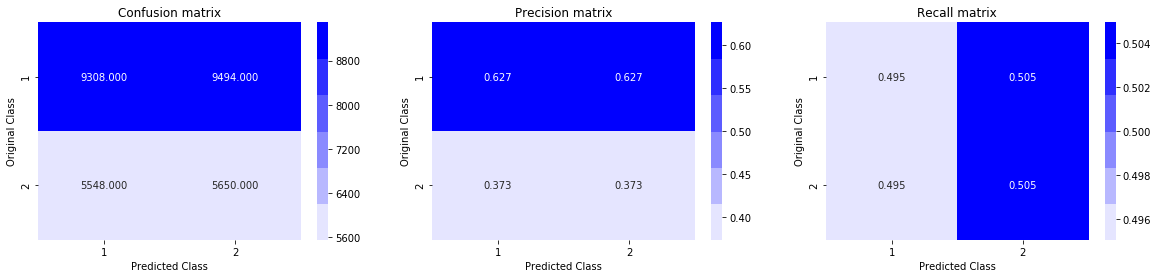

In [19]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
test_len=len(test_y)
train_len=len(train_y)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(test_y, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(test_y, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.4351425312550079
For values of alpha =  0.0001 The log loss is: 0.4110766909557982
For values of alpha =  0.001 The log loss is: 0.4325236277249608
For values of alpha =  0.01 The log loss is: 0.44475411980627955
For values of alpha =  0.1 The log loss is: 0.46223134216931444
For values of alpha =  1 The log loss is: 0.494057684717291
For values of alpha =  10 The log loss is: 0.5471522280204012


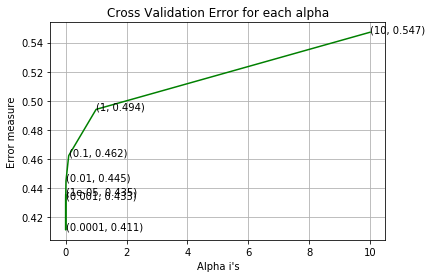

For values of best alpha =  0.0001 The train log loss is: 0.4068090799640079
For values of best alpha =  0.0001 The test log loss is: 0.4110766909557982
Total number of data points : 30000


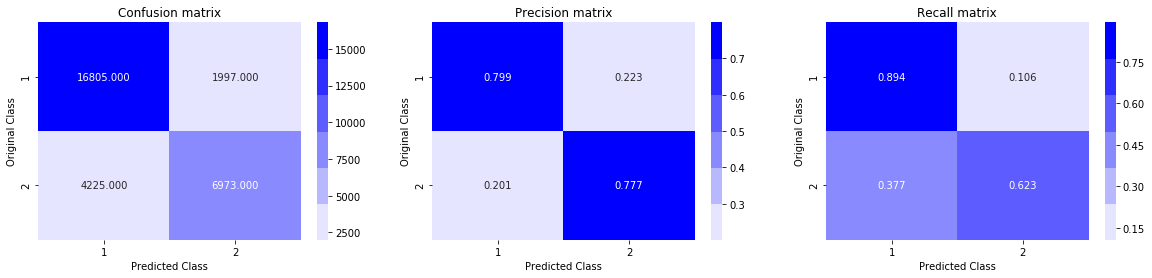

In [20]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train_final, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_final, train_y)
    predict_y = sig_clf.predict_proba(x_test_final)
    log_error_array.append(log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train_final, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_final, train_y)

predict_y = sig_clf.predict_proba(x_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_y, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.428998672266419
For values of alpha =  0.0001 The log loss is: 0.46300429809445737


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  0.001 The log loss is: 0.48144192214242315


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  0.01 The log loss is: 0.4852848285550551
For values of alpha =  0.1 The log loss is: 0.4791361219611149
For values of alpha =  1 The log loss is: 0.5805250716877347


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  10 The log loss is: 0.6212672736149758


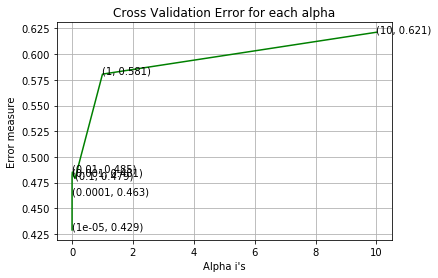

For values of best alpha =  1e-05 The train log loss is: 0.42824112249388085
For values of best alpha =  1e-05 The test log loss is: 0.4343660302777691
Total number of data points : 30000


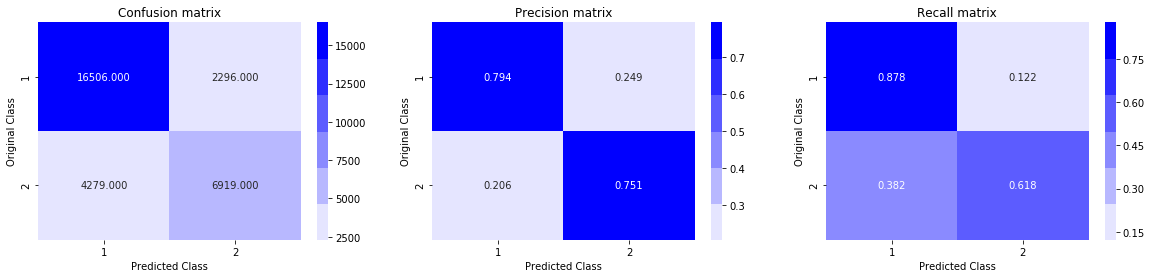

In [21]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, class_weight = "balanced")
    clf.fit(x_train_final, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_final, train_y)
    predict_y = sig_clf.predict_proba(x_test_final)
    log_error_array.append(log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train_final, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_final, train_y)

predict_y = sig_clf.predict_proba(x_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_y, predicted_y)

In [25]:
i=0
list_of_sentance_train=[]
x_tr_quest=x_tr_quest[x_tr_quest.notnull()]
for sentance in x_tr_quest:
    list_of_sentance_train.append(sentance.split())

In [26]:
i=0
list_of_sentance_test=[]
for sentance in x_test_quest:
    list_of_sentance_test.append(sentance.split())

In [27]:
from gensim.models import Word2Vec
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model_train.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_train.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
#w2v_model_train=scaler.fit_transform(w2v_model_train)

[('cool', 0.78558349609375), ('good', 0.731141984462738), ('fun', 0.7298749685287476), ('examples?', 0.7226507663726807), ('lesser', 0.7211296558380127), ('ideas', 0.7127143740653992), ('must-read', 0.7082751989364624), ('successful', 0.7031842470169067), ('interesting', 0.7005552053451538), ('unfair', 0.6882314085960388)]
[('craziest', 0.9187815189361572), ('strangest', 0.8771302103996277), ('scariest', 0.8634063601493835), ('biggest', 0.8617700338363647), ('experienced?What', 0.8449225425720215), ('funniest', 0.8434249758720398), ('saddest', 0.8316623568534851), ('greatest', 0.8224779367446899), ('coolest', 0.815280556678772), ('weirdest', 0.8126333951950073)]


In [28]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  17622
sample words  ['Why', "isn't", 'Indian', 'markets', 'hard', 'by', 'international', 'events', 'like', 'is', 'India', 'allowing', 'Chinese', 'companies', 'to', 'invest', 'freely', 'in', 'while', 'that', 'freedom', 'not', 'enjoyed', 'China?', 'why', 'the', 'sky', 'blue', 'where', 'there', 'are', 'no', 'What', 'does', 'mean', 'mathematics?What', 'trade', 'mean?', 'How', 'much', 'a', 'with', '5', 'million', 'subscribers', 'earn', 'year?How', 'do', 'YouTubers', 'without']


In [29]:
from tqdm import tqdm
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))


100%|██████████| 69999/69999 [02:00<00:00, 582.22it/s]

69999
50


In [30]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 30000/30000 [00:51<00:00, 580.38it/s]

30000
50


In [31]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_train= TfidfVectorizer()
tf_idf_matrix_train = model_train.fit_transform(x_tr_quest)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model_train.get_feature_names(), list(model_train.idf_)))

In [32]:
# TF-IDF weighted Word2Vec

tfidf_feat_train = model_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec_train = np.zeros(50) # as word vectors are of zero length
    weight_sum_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_train:
            vec_train = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf= dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec_train += (vec * tf_idf)
            weight_sum_train += tf_idf
    if weight_sum_train != 0:
        sent_vec_train /= weight_sum_train
    tfidf_sent_vectors_train.append(sent_vec_train)
    row += 1

100%|██████████| 69999/69999 [12:36<00:00, 92.55it/s] 


In [33]:
tfidf_feat_test = model_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec_test = np.zeros(50) # as word vectors are of zero length
    weight_sum_test =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_test:
            vec_test = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec_test += (vec * tf_idf)
            weight_sum_test += tf_idf
    if weight_sum_test != 0:
        sent_vec_test /= weight_sum_test
    tfidf_sent_vectors_test.append(sent_vec_test)
    row += 1


100%|██████████| 30000/30000 [05:33<00:00, 90.09it/s] 


In [45]:
train_feats=train_feats[0:69999]
x_train_final_tfidf =scipy.sparse.hstack((tfidf_sent_vectors_train, train_feats.astype(float)))
x_test_final_tfidf =scipy.sparse.hstack((tfidf_sent_vectors_test, test_feats.astype(float)))
print(x_train_final_tfidf.shape)
print(x_test_final_tfidf.shape)

(69999, 76)
(30000, 76)


In [46]:
x_train_final_tfidf= np.hstack((tfidf_sent_vectors_train, train_feats))
x_test_final_tfidf =np.hstack((tfidf_sent_vectors_test, test_feats))
print(x_train_final_tfidf.shape)
print(x_test_final_tfidf.shape)

(69999, 76)
(30000, 76)


In [49]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
train_y=train_y[0:69999]
tuned_parameters={'n_estimators':[1,5,10,50],'max_depth':[1,5,10,50]}
model=RandomizedSearchCV(xgb.XGBClassifier(),tuned_parameters,scoring='neg_log_loss',cv=3)
model.fit(x_train_final_tfidf,train_y)
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [52]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 10
params['n_estimators']=50
d_train = xgb.DMatrix(x_train_final_tfidf, label=train_y)
d_test = xgb.DMatrix(x_test_final_tfidf, label=test_y)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train_final,train_y)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.682553	valid-logloss:0.682999
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.595721	valid-logloss:0.600288
[20]	train-logloss:0.53381	valid-logloss:0.541793
[30]	train-logloss:0.487162	valid-logloss:0.498853
[40]	train-logloss:0.450637	valid-logloss:0.465968
[50]	train-logloss:0.422364	valid-logloss:0.440977
[60]	train-logloss:0.399781	valid-logloss:0.421262
[70]	train-logloss:0.381694	valid-logloss:0.405758
[80]	train-logloss:0.366891	valid-logloss:0.393532
[90]	train-logloss:0.354559	valid-logloss:0.383746
[100]	train-logloss:0.344101	valid-logloss:0.375728
[110]	train-logloss:0.335584	valid-logloss:0.369326
[120]	train-logloss:0.328403	valid-logloss:0.364327
[130]	train-logloss:0.322407	valid-logloss:0.360242
[140]	train-logloss:0.31737	valid-logloss:0.357069
[150]	train-logloss:0.313039	valid-logloss:0.354363
[160]	train-logloss:0.309349	v

Total number of data points : 30000


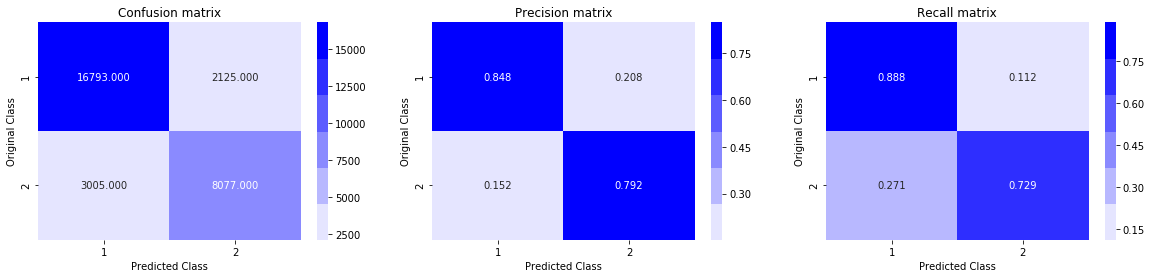

In [53]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_y, predicted_y)